# Les Versions de l'article 9

In [66]:
#import des modules
#lecture des json
import json 
#affichage des dictionnaires avec idententation
import pprint
pp = pprint.PrettyPrinter(indent=4, )
#librairie des graphes
import networkx as nx
#affichage des graphs
import matplotlib
import matplotlib.pyplot as plt
#calcul
import numpy as np
from itertools import combinations
%matplotlib inline

In [67]:

#chargement de l'article 9
with open("article9.json", "r") as f:
    article9 = json.load(f)

* On va stocker le détail des participations de l'article 9 dans version_originale de la manière suivante:

In [68]:
#Pour rappel
#print article9.keys()
version_originale = {
                "date": article9["created_at"],
                "link": article9["article_link"],
                "slug": article9["article_link"].split("/")[-1],
                "title": article9["article_link"].split("/")[-1].replace("-", " "),
                "text": article9['body'],
                "author": article9["author"],
                "votes":[], 
                "arguments":article9["arguments"], 
                "votes_arguments": [],
                "sources":article9["sources"],
                "votes_sources": [],
                "total_votes": article9["votes_total"],
                #les décomptes de votes sur les arguments ne sont pas disponible dans l'article9
                  # seulement le nombre d'arguments
                "total_arguments_votes": article9["arguments_count"]
               }

* On va stocker les versions complémentaires dans versions

In [69]:
versions = article9["versions"]


et reformater les versions de la même manière que dans la version originale


In [70]:
versions_c = []
for v in versions:
    #pour rappel
    #print v.keys()
    vn = {"date":v["created_at"],
            "link":v["link"],
            "slug":v["slug"],
            "title":v["title"],
            "text": v['comment'],
            "author": v["author"],
            "votes":[], 
            "arguments":[], 
            "votes_arguments": [],
            "sources":[],
            "votes_sources": [],
            "total_votes":v["votes_total"],
          #ici il s'agit bien du nombre de votes sur un argument
            "total_arguments_votes": v["arguments_count"]
         }
    versions_c.append(vn)

* On ajoute ensuite la version originale

In [71]:
versions_c.append(version_originale)

* Maintenant on va le transformer en dictionnaire avec pour clé le numero de version
en fonction de la date

In [128]:
versions_c = sorted(versions_c, key=lambda k: k['date'])
versions_nb = {}
versions_d = {}
for i,v in enumerate(versions_c):
    versions_nb["V"+str(i)] = v
    versions_d[v["slug"]] = v
#Le premier est bien la V0   
print "Version 0:\n", versions_nb["V0"]["slug"]
#Le dernier est :
print "Version 108:\n", versions_nb["V108"]["slug"]

Version 0:
article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics
Version 108:
distinguer-shs-et-stem-ne-reconnait-pas-les-recherches-interdisplinaires-quelle-premiere-publication-quelle-version


In [129]:
#On vérifie le nombre de versions
print len(versions_d)

109


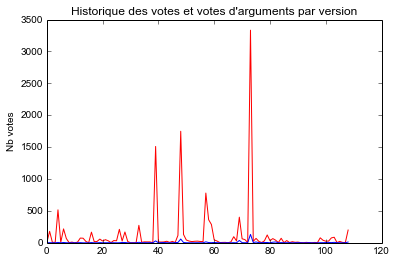

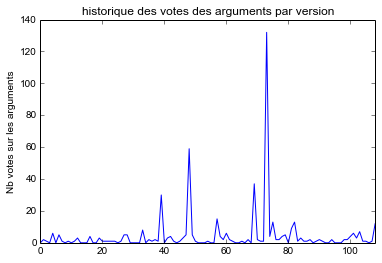

In [132]:
N = len(versions_d)
votes_infos = [v["total_votes"]  for v in versions_nb.values()]
import pylab
args_infos = [v["total_arguments_votes"]  for v in versions_nb.values()]
plt.title("Historique des votes et votes d'arguments par version")
plt.ylabel('Nb votes')
#pylab.xlim([0,108])
plt.plot(votes_infos,color='r')
plt.plot(args_infos,color='b')

plt.show()
plt.title("historique des votes des arguments par version")
plt.ylabel('Nb votes sur les arguments')
pylab.xlim([0,108])
plt.plot(args_infos,color='b')


# Les electeurs de l'article 9

On charge le fichiers participants qui contient toutes les actions de chaque participant

In [193]:

#Ici on ne s'intéresse qu'aux votes
#qui sont détaillés par participants
with open("participants.json", "r") as f:
    data = json.load(f)
    participants = data["participants"]
#Verifions le nombre de participants

print len(participants), "participants sur l'ensemble des articles"
#les noms des participants
electeurs = list(set([n.keys()[0] for n in participants]))


21329 participants sur l'ensemble des articles


On charge ensuite seulement les votes des électeurs de l'article 9 dans votes
et les electeurs de l'article 9 dans electeurs_d

In [194]:
art = "article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics"
votes = []
electeurs_d = {}
for user in participants:
    #accesible via son nom
    name =  user.keys()[0]
    electeurs_d[name] = []
    #récupérer les votes de l'utilisateur dans "votes"
    #filtrer ceux qui ont des votes qui correspondent à l'article
    for vote in user[name]["votes"]:
        if art in vote["link"]:
            vote["electeur"] = name
            electeurs_d[name].append(vote)
            if vote not in votes:
                votes.append(vote)
#On enleve les electeurs qui n'ont pas voté pour l'article
electeurs_d = {k:v for k,v in electeurs_d.items() if v != []}  

In [136]:
print len(votes), "votes sur des articles, arguments ou sources"
print len(electeurs_d), "electeurs"

15547 votes sur des articles, arguments ou sources
5651 electeurs


### Les votes de l'article 9
On ajoute les informations de votes pour chaque version de l'article:
* les votes sur les arguments
* les votes sur les sources
* les votes sur les versions

In [137]:
for vote in votes:
    url = vote["link"]
    slug = url.split("/")[-1]
    #vote sur un argument        
    if "#arg" in slug:
        vote["slug"], vote["id"] = slug.split("#")
        versions_d[vote["slug"]]["votes_arguments"].append(vote)
        
        #vote sur une source
    elif "#source" in slug:
        vote["slug"], vote["id"] = slug.split("#")
        versions_d[vote["slug"]]["votes_sources"].append(vote)
        
    #vote sur un article
    else:
        vote["slug"] = slug
        versions_d[vote["slug"]]["votes"].append(vote)
        

In [138]:
print len(versions_d[art]),"versions de l'article"
print len(versions_d[art]["votes"]),"votes par version"

13 versions de l'article
3334 votes par version


In [19]:
print len(versions_d[art]["sources"]), "sources pour l'articles"
print len(versions_d[art]["votes_sources"]), "votes sur les sources de l'article"

22


In [20]:
print len(versions_d[art]["arguments"]), "arguments pour l'article"
print len(versions_d[art]["votes_arguments"]), "votes sur les arguments de l'article"

132


In [140]:
#version à plat des couples votants, electeurs
auteur_electeur = []
for version, data in versions_d.items():
    for vote in data["votes"]:
        auteur_electeur.append([version, data["author"], vote["electeur"], vote["opinion"]])


In [141]:
print len(auteur_electeur)

12851


In [142]:
with open("votes_auteur_electeur.csv", "w") as f:
    f.write("version\tauteur\telecteur\tvote\n")
    for line in auteur_electeur:
        f.write(("\t").join(line)+"\n")
        

## Reseau de soutien d'un electeur à auteur

### Les pour
Nous allons construire un premier graphe simple:
* les points sont les electeurs et les auteurs d'une version de l'article
* les aretes ou les liens représente un ou plusieur votes d'un electeur **pour** une version proposée par l'autre
    => Deux acteurs sont reliés dès lors que l'un d'entre eux a voté **pour** une version proposé par l'autre.

### Les contres

De la même manière pour les contre


## Familles d'electeurs: les comportement de votes

Deux electeurs sont reliés quand ils ont votés de manière similaires selon 
un score de similiarité de comportement de votes que nous allons construire:

Avant de procéder à cette analyse regardons donc la répartition de participations des électeurs

Un nombre de votes par electeur situé entre 1 et 102
On a 5635 electeurs pour un total de 12851 votes dont x qui a voté une fois

On va d'abord se concentrer sur les electeurs qui ont votés plusieurs fois.
Et ensuite chercher un seuil minimal de participation pour détecter la similarité entre 
deux electeurs.

En effet si un electeur a voté une seule fois et qu'un autre electeur 15 fois
leur comportement est similaire alors que ce n'est pas révélateur

In [144]:
from collections import Counter
import operator
votes_electeurs = Counter([n[2] for n in auteur_electeur])
nb_electeurs = len(votes_electeurs)
nb_votes = sum(votes_electeurs.values())
print nb_votes,"votes", nb_electeurs, "electeurs"
#top_votants = votes_electeurs.most_common(563)

#print top_votants

#plt.bar(range(len(top_votants)), top_votants.values(), align='center')
#plt.xticks(range(len(top_votants)), range(len(top_votants)))
#plt.show()

one_vote = {k:v for k,v in votes_electeurs.items() if v ==1}
nb_one_vote = len(one_vote)
print nb_one_vote, "electeurs uniques qui ont voté une seule fois"
multiple_vote = {k:v for k,v in votes_electeurs.items() if v > 1}
print len(multiple_vote), "electeurs uniques qui ont voté plusieurs fois"
print "pour un total de", sum(multiple_vote.values()), "votes"
#seuil de participations = 5
votes_seuil = {k:v for k,v in votes_electeurs.items() if v >= 5}
print len(votes_seuil), "participants ont votés au moins 5 fois et produit au total:",  sum(votes_seuil.values()), "votes"


12851 votes 5635 electeurs
3043 electeurs uniques qui ont voté une seule fois
2592 electeurs uniques qui ont voté plusieurs fois
pour un total de 9808 votes
482 participants ont votés au moins 5 fois et produit au total: 4574 votes


In [145]:
from itertools import combinations
from math import factorial as fact
combo = list(set(combinations(votes_seuil.keys(), 2)))

print len([n for n in combo]), "couples de participants"

def combo_score(n,k):
    #en combinatoire calculer le nombre de combinaison de 2 elements sur un ensemble de 482 elements
    #https://fr.wikipedia.org/wiki/Combinaison_(math%C3%A9matiques)
    #combin = lambda n,k: fact(n)//(fact(k)*fact(n-k))
    return fact(n)/(fact(k)*fact(n-k))
#Pour vérifier les combinaisons
#print combo_score(482, 2)


115921 couples de participants


#### Le graphe des electeurs similaires

* Chaque noeud correspond à un électeur
* Deux electeurs sont reliés si leur score de similarite est > 0
* La taille du lien dépend du score de similarité
* La taille du noeud dépend du nombre de votes de la personne
* Les électeurs non reliés à d'autres électeurs seront supprimés (les noeuds isolés n'apparaitront pas)

In [203]:
#le seuil de similarité
#SEUIL = 0
#construction des liens
def build_graph(votes_seuil,electeurs_d, versions_d, SEUIL=0):
    #construction des familles par similarité de votes
    #on crée un dictionnaire qui contiendra les couples
    #et leur score de similarité
    similarity_score = {}
    #On crée un graphe        
    g = nx.Graph()
    #Avec la spatialisation selon l'algo de clusterisation Fruchert
    pos = nx.spring_layout(g)
    #On déroule les couples
    for couple in combinations(votes_seuil.keys(), 2):
        
        userA, userB = couple
        #on ajoute les noeuds
        g.add_node(userA, weight=len(electeurs_d[userA]))
        g.add_node(userB, weight=len(electeurs_d[userB]))
        #On met le score à 0
        similarity_score[c] = 0
        #Pour chaque version
        for v, k in versions_d.items():
            electeur_vote = {e["electeur"]:e["opinion"] for e in k["votes"]}
            print electeur_vote
            break
        break
            
graph1 = build_graph(votes_seuil,electeurs_d, versions_d, SEUIL=1)



{u'gregoire': u'-1', u'barrierejeanpaul': u'1', u'jeannevarasco': u'1', u'syndicatnationaldeledition': u'1', u'fabienandre': u'-1', u'editionsdalloz': u'1', u'vincentreverdy': u'-1'}


Evidemment on ne voit rien relançons avec un seuil de similarité de 3


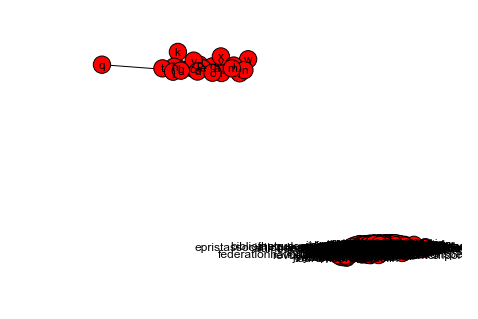

In [171]:
add_edges(3)

# Réseau d'affinité entre l'auteur et ses electeurs:

Deux acteurs sont reliés lorsque que l'un à voté *pour* l'autre


In [ ]:
auteur_vs_electeur = { "auteur":[], "electeur":[], "vote":[], "version":[]}
for line in auteur_electeur:
    auteur_vs_electeur["version"].append(line[0])
    auteur_vs_electeur["auteur"].append(line[1])
    auteur_vs_electeur["electeur"].append(line[2])
    auteur_vs_electeur["vote"].append(line[3])
    

In [ ]:
from collections import defaultdict
#dictionnaire de auteur -> electeur
elu_par = defaultdict.fromkeys(set(auteur_vs_electeur["auteur"]), [])
#dictionnaire de electeur -> version
a_vote_pour = defaultdict.fromkeys(set(auteur_vs_electeur["electeur"]), [])
votes_pour = []
with open("a_vote_pour.csv","w") as f:
    f.write("auteur\telecteur\tversion\n")
    for line in auteur_electeur:
        auteur = line[1]
        electeur = line[2]
        version = line[0]
        if line[3] == "1":
            
            votes_pour.append(line)
            f.write("\t".join(line[0:3])+"\n")
            elu_par[auteur].append(electeur)              
            a_vote_pour[electeur].append(version)
        


In [ ]:
import networkx as nx

In [ ]:
def find_isolated_nodes(graph):
    """ returns a list of isolated nodes. """
    isolated = []
    for node in graph:
        if not graph[node]:
            isolated += node
    return isolated
isolated = find_isolated_nodes(elu_par)
print isolated

les noeuds seront les auteurs
et les edges les votes pour

In [ ]:
G = nx.Graph()
#G.add_nodes_from(elu_par.keys(), type="auteur")


for k,v in elu_par.items():
    nx.set_node_attributes(G,k, k)
    for v2 in v:
        G.add_edge(k,v2)

nx.draw(G)
plt.show()


In [ ]:
G = nx.Graph()